In [1]:
import pickle
import pandas as pd
from tqdm import tqdm

In [2]:
ideology_df = pd.read_csv('./data/processed_annotated_comments.csv')
ideology_df['label'] = ideology_df['label'].apply(lambda x: None if x not in ['left', 'right'] else x)
ideology_df.dropna(inplace=True)

main_df = pd.read_csv('./data/jigsaw/main.csv')
dfs = [ideology_df, main_df] 
names = ['ideology', 'jigsaw']

In [3]:
# load preprocessed results
with open('./results/moderation_results.pkl', 'rb') as file:
    fairness_results = pickle.load(file)


gold1 = {k:v['openai'] for k,v in fairness_results.items()}
gold2 = {k:v['perspective'] for k,v in fairness_results.items()}
gold3 = {k:v['google'] for k,v in fairness_results.items() if v['google'] in [True, False]}
gold4 = {k:v['clarifai'] for k,v in fairness_results.items()}

gold1 = {k: 1 if v is True else 0 for k,v in gold1.items()}
gold2 = {k: 1 if v is True else 0 for k,v in gold2.items()}
gold3 = {k:1 if v is True else 0 for k,v in gold3.items()}
gold4 = {k:1 if v is True else 0 for k,v in gold4.items()}

In [4]:
from collections import defaultdict

def percent_index_level_changes(A, B, model):
    if len(A) != len(B):
        raise ValueError("Lists A and B must be of the same length.")
    

    changes = defaultdict(lambda: defaultdict(int))
    category_counts = defaultdict(int)
    

    for i in range(len(A)):
        changes[A[i]][B[i]] += 1
        category_counts[A[i]] += 1
    
    percent_changes = {
        key: {inner_key: (count / category_counts[key])
              for inner_key, count in inner_dict.items()} 
        for key, inner_dict in changes.items()
    }
    
    return percent_changes

In [5]:
golds = [gold1, gold2, gold3, gold4]

methods = ['openai', 'perspective','google', 'clarifai']
perturbations = ['german', 'gpt_3.5_turbo']

results = []
global_results = {}

perturbation_map = {}
with open('./results/comments_backtranslated_german_similarity.pkl', 'rb') as handle:
        perturbation_map[perturbations[0]] = pickle.load(handle)

with open('./results/comment_paraphrased_gpt-3.5_final.pkl', 'rb') as handle:
        perturbation_map[perturbations[1]] = pickle.load(handle)

for method in methods:
    global_results[method] = {}

for perturbation in perturbations:
    with open(f'./results/moderation_results_fairness_perturbed_{perturbation}.pkl', 'rb') as handle:
        fairness_results = pickle.load(handle)
    
    phrase_map = perturbation_map[perturbation]
    if perturbation == "german":
        phrase_map = {k:v['augmented'] for k,v in phrase_map.items() if v['score'] > 0.85 and v['score'] != 1.0}

    for gold, method in zip(golds, methods):
        local_gold = gold.copy()
        
        # check to ignore NULL values for phrases where moderation did not run
        fairness_results = {k:v for k,v in fairness_results.items() if fairness_results[k][method] in [True, False]}
        
        data = {k:int(fairness_results[v][method]) for k,v in phrase_map.items() if v in fairness_results.keys()}

        local_gold = {k:v for k,v in local_gold.items() if k in data.keys() and v in [True, False]}


        # create lists and compute robustness
        global_results[method][perturbation] = {}
        for subset, name in zip(dfs, names):
            df = subset.copy()
            df = df[df['text'].isin(list(local_gold.keys()))]
            # align indices and verify
            a = ['UNSAFE' if local_gold[k] == 1 else 'SAFE' for k in df['text'].tolist()]
            b = ['UNSAFE' if data[k] == 1 else 'SAFE' for k in df['text'].tolist()]
            change_map = percent_index_level_changes(a, b, method)
            global_results[method][perturbation][name] = change_map
            # break


In [15]:
global_results

{'openai': {'german': {'ideology': {'SAFE': {'SAFE': 0.9626038781163435,
     'UNSAFE': 0.037396121883656507},
    'UNSAFE': {'UNSAFE': 0.8897058823529411, 'SAFE': 0.11029411764705882}},
   'jigsaw': {'UNSAFE': {'UNSAFE': 0.9181740134403031,
     'SAFE': 0.08182598655969685},
    'SAFE': {'SAFE': 0.9635810699465177, 'UNSAFE': 0.036418930053482346}}},
  'gpt_3.5_turbo': {'ideology': {'SAFE': {'SAFE': 0.988009592326139,
     'UNSAFE': 0.011990407673860911},
    'UNSAFE': {'SAFE': 0.7028753993610224, 'UNSAFE': 0.2971246006389776}},
   'jigsaw': {'UNSAFE': {'UNSAFE': 0.34940427443003197,
     'SAFE': 0.650595725569968},
    'SAFE': {'SAFE': 0.9797244537381384, 'UNSAFE': 0.02027554626186159}}}},
 'perspective': {'german': {'ideology': {'SAFE': {'SAFE': 0.9914110429447853,
     'UNSAFE': 0.008588957055214725},
    'UNSAFE': {'UNSAFE': 0.9385474860335196, 'SAFE': 0.061452513966480445}},
   'jigsaw': {'UNSAFE': {'UNSAFE': 0.9350671001083605,
     'SAFE': 0.06493289989163957},
    'SAFE': {'SAF

[{'UNSAFE': {'UNSAFE': 0.9181740134403031, 'SAFE': 0.08182598655969685}, 'SAFE': {'SAFE': 0.9635810699465177, 'UNSAFE': 0.036418930053482346}}, {'UNSAFE': {'UNSAFE': 0.9350671001083605, 'SAFE': 0.06493289989163957}, 'SAFE': {'SAFE': 0.991607649125185, 'UNSAFE': 0.008392350874815041}}, {'UNSAFE': {'UNSAFE': 0.972053046481584, 'SAFE': 0.027946953518415987}, 'SAFE': {'SAFE': 0.9191558441558442, 'UNSAFE': 0.08084415584415584}}, {'UNSAFE': {'UNSAFE': 0.8767123287671232, 'SAFE': 0.1232876712328767}, 'SAFE': {'SAFE': 0.9898993144815766, 'UNSAFE': 0.010100685518423308}}]


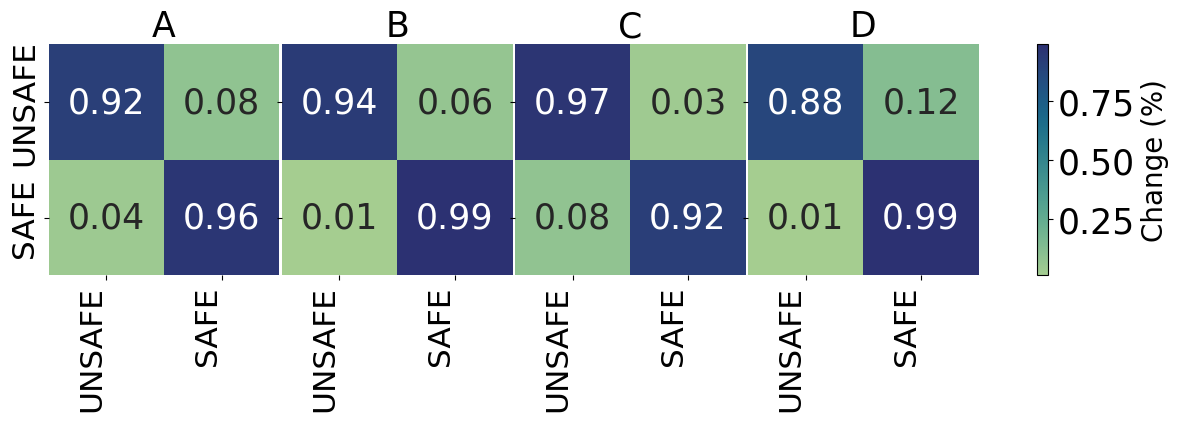

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = ['UNSAFE', 'SAFE']
titles = ["A", "B", "C", "D"] #['OpenAI', 'Perspective', 'PaLM2', 'Clarifai']

data=[v['german']['jigsaw'] for k,v in global_results.items()]
print(data)

heatmap_data = [np.zeros((2,2)) for _ in range(len(data))]

global_max = -np.inf
global_min = np.inf

for i, row in enumerate(data):
    for j, col in enumerate(row.values()):
        for k, val in enumerate(col.values()):
            heatmap_data[i][j, k] = val
            if val > global_max:
                global_max = val
            if val < global_min:
                global_min = val

fig, axes = plt.subplots(1, len(data), figsize=(15,3), sharey=True)
fig.subplots_adjust(wspace=0.01)
for i, ax in enumerate(axes):
    df = pd.DataFrame(data[i]).fillna(0).T
    sns.heatmap(df, annot=True, fmt=".2f", cmap="crest", ax=ax, annot_kws={"size":25}, vmin=global_min, vmax=global_max, cbar=False)
    ax.set_title(titles[i], fontsize=25)
    ax.xaxis.set_tick_params(labelsize=22.5)
    ax.yaxis.set_tick_params(labelsize=22.5)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical')
cbar.set_label('Change (%)')
cbar.ax.tick_params(labelsize=25)
cbar.ax.yaxis.label.set_size(20)

plt.show()